In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# CONTENTS
1. Introduction
2. Tensor
3. Data
4. Implementing a Model

## PyTorch
1. Tensor Library for DL using GPU&CPU

2. Autograd Engine
    * does backprop automatically
    * (do this by) storing gradietns for all tensors in networks and using them to do backprop
    
3. Define-by-run (cf : Define-and-run with Tensorflow)
    * dynamic network dynamically, more model flexibility (?)

In [2]:
import torch

In [6]:
torch.backends.mps.is_available()

True

# 1. Tensor

Attributes
* `shape`
    * `unsqueeze`, `squeeze` : (`(2) <-> (1,2)`)
    * `reshape` : (`(4)-> (2,2)`)
    * `permute` : (`(3,1,4) -> (4,1,3)`) (dimension swap)
* `dtype`
* `device` => which device the tensor is in

In [3]:
###########################
#### tensor attributes ####
###########################

t1 = torch.zeros(4,2)
print(t1)
print(t1.shape)
print(t1.dtype)
print(t1.device)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])
torch.Size([4, 2])
torch.float32
cpu


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#t1_gpu = t1.cuda(device)
#print(t1_gpu.device)
print(t1.device)

cpu


In [16]:
#moving the M1 GPU instead
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
t1_gpu = t1.to(device)
print(t1_gpu.device)
print(t1.device)


mps:0
cpu


In [17]:
###########################
### squeeze & unsqueeze ###
###########################

t2 = torch.rand(2)
print("t2: ")
print(t2)
print(t2.shape)

print("\n---after unsqueeze---")
t2_add_rank = t2.unsqueeze(0)
print(t2_add_rank)
print(t2_add_rank.shape) # 1,2

# print(t2_add_rank.unsqueeze(1).shape) # 1, 1 ,2

t2: 
tensor([0.5506, 0.5383])
torch.Size([2])

---after unsqueeze---
tensor([[0.5506, 0.5383]])
torch.Size([1, 2])


In [18]:
t3 = torch.rand(1,2)
print(t3)
print(t3.shape)

print("\n---after squeeze---")
t3_delete_rank = t3.squeeze(0)
print(t3_delete_rank)
print(t3_delete_rank.shape)

tensor([[0.6088, 0.4006]])
torch.Size([1, 2])

---after squeeze---
tensor([0.6088, 0.4006])
torch.Size([2])


In [19]:
###########################
#### reshape & permute ####
###########################

t4 = torch.rand(192) # 3*8*8
print(t4.shape)

t4 = t4.reshape(3, 8, 8)
print("\n---after reshape---")
print(t4.shape)

t4 = t4.permute(1,2,0)
print("\n---after permute---")
print(t4.shape)


torch.Size([192])

---after reshape---
torch.Size([3, 8, 8])

---after permute---
torch.Size([8, 8, 3])


In [20]:
# 실제 값 이동 확인
# t4 = torch.rand(12)
# print('\n',t4)
# t4 = t4.reshape(3,2,2)
# print('\n',t4)
# t4 = t4.permute(1,2,0) # (2,2,3)
# print('\n',t4)

In [21]:
###########################
#### Basic operations #####
###########################

import numpy as np
import torch

# convert numpy -> tensor
num_array = np.array([[1,2],[3,4]])
t5 = torch.Tensor(num_array)
print(type(num_array))
print(num_array)
print(type(t5))
print(t5)

<class 'numpy.ndarray'>
[[1 2]
 [3 4]]
<class 'torch.Tensor'>
tensor([[1., 2.],
        [3., 4.]])


In [22]:
# elementwise operations
t6 = torch.ones_like(t5) # tensor filled w/ value '1' in the same shape of t5
output = t5 + 2 * t6
print(output)

print()
print("exponential: ")
print(torch.exp(output))

tensor([[3., 4.],
        [5., 6.]])

exponential: 
tensor([[ 20.0855,  54.5981],
        [148.4132, 403.4288]])


In [23]:
# broadcasting
vector = torch.ones((2,1)) # shape: (2,1)
broadcast_output = output + vector
print(broadcast_output)

vector_err = torch.ones((3,1)) # shape: (3,1)
# broadcast_output = output + vector_err # Raise Error!

tensor([[4., 5.],
        [6., 7.]])


In [24]:
# dimension reduction
t7 = torch.randn((2,3,4)) # shape: (2,3,4) = (0th dim, 1st dim, 2nd dim)
print(t7)
print()

t7_argmax = torch.argmax(t7, dim=1)
print(t7_argmax.shape)
print(t7_argmax)

print()

print(torch.argmax(t7, 1, keepdims=True).shape)
# print(torch.argmax(t7, 1, keepdims=True))
print(torch.argmax(t7, 1, keepdims=True).squeeze(1).shape)

tensor([[[ 0.3735, -1.7626,  0.7899, -0.8324],
         [-0.0863, -0.0743, -0.3117, -0.3652],
         [-0.1959, -1.8726,  0.5492,  0.8871]],

        [[ 1.1122, -1.4885,  0.1570,  2.0678],
         [-0.3380,  1.2452, -0.5682,  1.2220],
         [ 1.5029, -0.1173,  2.1450, -0.2366]]])

torch.Size([2, 4])
tensor([[0, 1, 0, 2],
        [2, 1, 2, 0]])

torch.Size([2, 1, 4])
torch.Size([2, 4])


# 2. Dataset & DataLoader

In [25]:
###############################
# Define dataset & dataloader #
###############################
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random

class SimpleDataset(Dataset):

    def __init__(self, csv_file=None, root_dir=None):

        #self.csv_file = csv_file
        #self.root_dir = root_dir

        # set x_data with random length
        n_dataset = 100
        self.x_data = []
        for _ in range(n_dataset):
            random_length = random.randint(5,10)
            self.x_data.append(np.random.randint(0,255,random_length))
        # set y_data
        self.y_data = torch.rand(n_dataset, 1)

        print("SimpleDataset setting done")
        print(f'x_data shape: {len(self.x_data)}')
        print(f'x_data random length (1st, 4th, 46th): {len(self.x_data[0]),len(self.x_data[3]), len(self.x_data[45])}')
        print(f'y_data shape: {self.y_data.shape}')
    
    def __len__(self): 
        return len(self.x_data)

    def __getitem__(self, idx): 
        x = torch.FloatTensor(self.x_data[idx])
        y = torch.FloatTensor(self.y_data[idx])
        return x, y 
    
    def collate_fn(self, data):
        
        max_len = 10
        batch = []
        for x, y in data:
            x_padded = torch.cat([x, torch.zeros(max_len - x.shape[0])])
            batch.append(x_padded)
        return torch.stack(batch)

dataset = SimpleDataset() #instantiate the custom dataset class

SimpleDataset setting done
x_data shape: 100
x_data random length (1st, 4th, 46th): (5, 6, 9)
y_data shape: torch.Size([100, 1])


In [27]:
dataloader = DataLoader(dataset, batch_size=25, collate_fn=dataset.collate_fn, shuffle=True)
#dataloader = DataLoader(dataset, batch_size=25, shuffle=True) # Raise Error!

for batch_idx, samples in enumerate(dataloader):
    print("batch idx: ", batch_idx+1)
    print("sample shape: ", samples.shape)

    if batch_idx==len(dataloader)-1:
        print(samples)

    # ... train continued

batch idx:  1
sample shape:  torch.Size([25, 10])
batch idx:  2
sample shape:  torch.Size([25, 10])
batch idx:  3
sample shape:  torch.Size([25, 10])
batch idx:  4
sample shape:  torch.Size([25, 10])
tensor([[ 54.,  29., 125.,  45.,   9., 125.,   0.,   0.,   0.,   0.],
        [159., 132., 202.,  67., 116., 242., 195., 253., 137.,   0.],
        [147.,   5., 128., 228.,  44.,  86., 186.,   0.,   0.,   0.],
        [128., 224., 114., 253.,  37., 150.,   0.,   0.,   0.,   0.],
        [112., 145.,  48., 230.,  55.,   0.,   0.,   0.,   0.,   0.],
        [195., 205.,  13., 204., 162.,   0.,   0.,   0.,   0.,   0.],
        [203.,  97., 252.,   8.,  63.,  17.,  75., 173., 224.,  44.],
        [127., 126., 183., 101., 117.,   0.,   0.,   0.,   0.,   0.],
        [209.,  78.,  97.,  79., 141.,   0.,   0.,   0.,   0.,   0.],
        [236., 124., 154.,  44., 199.,  36., 193., 199., 174., 235.],
        [144.,   1., 110.,  38., 152., 110., 179.,  30.,   0.,   0.],
        [198.,  22.,  85.,   3

# 3. Implementating a Model

## 3-1. Preparing dataset(MNIST)

In [28]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# set dataset
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False, #유일하게 `train_data`와 다른점! 
    download=True,
    transform=ToTensor()
)

# set data loader (Dataloader options를 넣자)
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

example data shape:  torch.Size([64, 1, 28, 28])


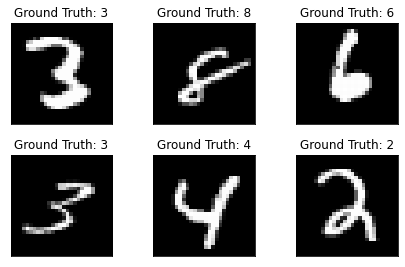

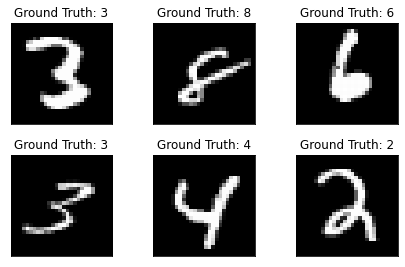

In [35]:
import matplotlib.pyplot as plt

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print("example data shape: ", example_data.shape)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

## 3-2. Build Model



---




![image.png](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781492045342/files/assets/ppdl_0203.png)



ref.
Programming PyTorch for Deep Learning(2019), Ian Pointer, O'Reilly

In [29]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784,128)
        self.fc2 = nn.Linear(128,64)
        self.classifier = nn.Linear(64,10)
    
    def forward(self, x):
        x = x.reshape(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.classifier(x)

network = Net()
print(network)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (classifier): Linear(in_features=64, out_features=10, bias=True)
)


In [30]:
def train(model, optim, loss_fn, train_loader, epochs, device):
    for epoch in range(epochs):
        train_loss = 0.0
        model.train()

        for batch in train_loader:
            optim.zero_grad()
            
            input, target = batch
            input = input.to(device)
            target = target.to(device)
            
            output = model(input)
            loss = loss_fn(output, target)
            loss.backward()
            optim.step()
            train_loss += loss.data.item()
        train_loss /= len(train_loader.dataset)

        print(f'Epoch: {epoch+1}, Training Loss: {train_loss}')

def test(model, loss_fn, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    
    with torch.no_grad():
        for batch in test_loader:
            input, target = batch
            input = input.to(device)
            target = target.to(device)
            
            output = model(input)
            loss = loss_fn(output, target)
            test_loss += loss.data.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss},\t Accuracy: ({100. * correct / len(test_loader.dataset)}%)\n')

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
network.to(device) #put model on device
print(device)

num_epochs = 10
optimizer = optim.SGD(network.parameters(), lr=1e-2, momentum=0.9)
train(network, optimizer, nn.CrossEntropyLoss(), train_loader, num_epochs, device) #train with device also as option!
test(network, nn.CrossEntropyLoss(), device) #device also has to be specified!


#let's see if it's overfitting by printing out the history

#주의 : if I run it again without restarting the kernel, 이미 배워진 상태에서 다시 시작이 된다!

mps
Epoch: 1, Training Loss: 5.110583002397107e-06
Epoch: 2, Training Loss: 4.991611686538515e-06
Epoch: 3, Training Loss: 4.895933092863439e-06
Epoch: 4, Training Loss: 4.757114691574316e-06
Epoch: 5, Training Loss: 4.64800772901602e-06
Epoch: 6, Training Loss: 4.537871464435738e-06
Epoch: 7, Training Loss: 4.448293534619552e-06
Epoch: 8, Training Loss: 4.354357488231268e-06
Epoch: 9, Training Loss: 4.253709197526708e-06
Epoch: 10, Training Loss: 4.171076383359681e-06
Test Loss: 0.001478759228597687,	 Accuracy: (97.99000549316406%)



## 3-3. Save & Load Model

In [ ]:
# option 1
# save parameters & structure of model

# torch.save(network, "./data/first_network")
loaded_network = torch.load("./data/first_network")
print(loaded_network)
print(type(loaded_network))

In [ ]:
# option 2 (recommended)
# maps of each layer's parameters

# torch.save(network.state_dict(), "./data/first_network_dict")
# state_dict = torch.load("./data/first_network_dict")
# print(type(state_dict))

network.add_module("additional_layer", nn.Linear(10,10))
print(*network.modules())

In [ ]:
network.load_state_dict(state_dict, strict=False)
# network.load_state_dict(state_dict, strict=True) # Raise Error!
print(network)

In [ ]:
import torchvision.models as models

resnet18 = models.resnet18(pretrained=True)
print(resnet18)

In [ ]:
num_classes = 10
last_layer_in_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(last_layer_in_features, num_classes)
print(resnet18)

In [ ]:
train(model = network, optim = optimizer, loss_fn = loss_function,
     15      train_loader = train_loader, epochs = num_epochs, device = device)